# Libraries Load

In [620]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(rc={'figure.figsize':(20,10)})
plt.gcf().set_size_inches(11.7, 8.27)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from lightgbm.sklearn import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import shap
import pickle

<Figure size 842.4x595.44 with 0 Axes>

# Data Acquisition

In this specific project, the data is already handy and does not require manual scraping from airbnb website. we use existing data available on www.insideairbnb.com and we chose New York to be our city for exploration for the following reasons
* Enough records (37.6K)
* I live around and it connects back to my neighborhoods, and add interests to that particular project


In [621]:
def dataLoad():
    df_listings = pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2022-03-05/data/listings.csv.gz')
    print(f"loaded dataframe succesfully with {df_listings.shape} rows,cols")
    return df_listings

In [622]:
df_listings = dataLoad()

loaded dataframe succesfully with (37631, 74) rows,cols


In [623]:
df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20220305031505,2022-03-05,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,a few days or more,44%,18%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,5.0,5.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, United States",Midtown,Manhattan,40.75356,-73.98559,Entire rental unit,Entire home/apt,1,NaN,1 bath,NaN,1.0,"[""Bathtub"", ""Dishes and silverware"", ""Air cond...",$150.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,30,60,77,334,2022-03-05,48,0,0,2009-11-21,2019-11-04,4.70,4.72,4.62,4.76,4.79,4.86,4.41,NaN,f,3,3,0,0,0.32
1,5121,https://www.airbnb.com/rooms/5121,20220305031505,2022-03-05,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,2009-02-03,"New York, New York, United States","I am an artist(painter, filmmaker) and curato...",NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/72a61...,https://a0.muscache.com/im/pictures/user/72a61...,Bedford-Stuyvesant,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,NaN,Bedford-Stuyvesant,Brooklyn,40.68535,-73.95512,Private room in rental unit,Private room,2,NaN,NaN,1.0,1.0,"[""Kitchen"", ""Wifi"", ""Air conditioning"", ""Long ...",$60.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,30,60,90,365,2022-03-05,50,0,0,2009-05-28,2019-12-02,4.52,4.22,4.09,4.91,4.91,4.47,4.52,NaN,f,2,0,2,0,0.32
2,5136,https://www.airbnb.com/rooms/5136,20220305031505,2022-03-05,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,7378,https://www.airbnb.com/users/show/7378,Rebecca,2009-02-03,"Brooklyn, New York, United States","Rebecca is an artist/designer, and Henoch is i...",within an hour,100%,25%,f,https://a0.muscache.com/im/users/7378/profile_...,https://a0.muscache.com/im/users/7378/profile_...,Greenwood Heights,1.0,1.0,"['email', 'phone', 'reviews']",t,t,NaN,Sunset Park,Brooklyn,40.66265,-73.99454,Entire rental unit,Entire home/apt,4,NaN,1.5 baths,2.0,2.0,"[""Dryer"", ""Carbon monoxide alarm"", ""Kitchen"", ...",$275.00,5,1125,5.0,5.0,1125.0,1125.0,5.0,1125.0,NaN,t,0,0,0,201,2022-03-05,2,1,0,2014-01-02,2021-08-08,5.00,5.00,5.00,5.00,5.00,4.50,5.00,NaN,f,1,1,0,0,0.02


In [624]:
df_listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.763100e+04,3.763100e+04,3.763100e+04,37544.000000,37544.000000,37631.000000,37631.000000,37631.000000,0.0,33833.000000,36612.000000,37631.000000,3.763100e+04,37613.000000,37613.000000,3.761300e+04,3.761300e+04,37613.000000,3.761300e+04,0.0,37631.000000,37631.000000,37631.000000,37631.000000,37631.000000,37631.000000,37631.000000,28657.000000,28148.000000,28158.000000,28143.000000,28152.000000,28140.000000,28139.000000,37631.000000,37631.000000,37631.000000,37631.000000,28657.000000
mean,2.082548e+16,2.022031e+13,1.223235e+08,56.677871,56.677871,40.728692,-73.946879,2.839202,NaN,1.334525,1.602098,20.496638,5.875853e+04,20.805466,27.145588,1.543397e+06,3.541701e+06,26.650937,2.535292e+06,NaN,8.191969,18.610215,30.450745,129.085674,24.663044,6.046743,0.399112,4.605667,4.745793,4.619854,4.814639,4.807086,4.749410,4.648054,15.296723,8.293136,6.883447,0.058436,1.049115
std,1.056299e+17,7.613382e+00,1.366461e+08,346.748262,346.748262,0.056503,0.052921,1.908051,NaN,0.720233,1.114138,29.323780,1.107119e+07,35.197743,72.674726,5.751666e+07,8.711732e+07,70.805894,6.856545e+07,NaN,11.310459,22.985947,35.070272,140.624717,52.871878,16.838760,1.691176,0.786142,0.487119,0.565464,0.430519,0.457058,0.414962,0.511655,46.246180,38.117998,26.992907,0.552589,1.795620
min,2.595000e+03,2.022031e+13,2.438000e+03,0.000000,0.000000,40.504560,-74.249840,0.000000,NaN,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.415543e+07,2.022031e+13,1.204847e+07,1.000000,1.000000,40.688485,-73.983020,2.000000,NaN,1.000000,1.000000,2.000000,6.000000e+01,2.000000,3.000000,3.650000e+02,3.650000e+02,2.300000,3.650000e+02,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.580000,4.710000,4.500000,4.800000,4.810000,4.670000,4.560000,1.000000,0.000000,0.000000,0.000000,0.120000
50%,3.366773e+07,2.022031e+13,5.177239e+07,1.000000,1.000000,40.724690,-73.953880,2.000000,NaN,1.000000,1.000000,30.000000,3.670000e+02,30.000000,30.000000,1.125000e+03,1.125000e+03,30.000000,1.125000e+03,NaN,0.000000,3.000000,11.000000,66.000000,4.000000,0.000000,0.000000,4.820000,4.900000,4.800000,4.960000,4.970000,4.880000,4.780000,1.000000,1.000000,0.000000,0.000000,0.440000
75%,4.893624e+07,2.022031e+13,2.099219e+08,3.000000,3.000000,40.762215,-73.927845,4.000000,NaN,1.000000,2.000000,30.000000,1.125000e+03,30.000000,30.000000,1.125000e+03,1.125000e+03,30.000000,1.125000e+03,NaN,17.000000,37.000000,63.000000,275.000000,22.000000,4.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,1.000000,2.000000,0.000000,1.430000
max,5.751276e+17,2.022031e+13,4.477881e+08,3750.000000,3750.000000,40.916970,-73.705220,16.000000,NaN,15.000000,42.000000,1250.000000,2.147484e+09,1250.000000,1250.000000,2.147484e+09,2.147484e+09,1250.000000,2.147484e+09,NaN,30.000000,60.000000,90.000000,365.000000,1024.000000,849.000000,160.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,332.000000,332.000000,218.000000,11.000000,90.000000


## Data Preparation and Cleaning

### Data Cleaning

Choosing to drop/clean our data set from features that are unique and has no meaningful information towards understanding the data or feature engineering, such as serial number or picture url's. Also removing features with 100% missing values (that has been observed in imputation step)

In [625]:
features_to_drop = ['id','listing_url','scrape_id','last_scraped','picture_url','host_id','host_url','host_name','host_thumbnail_url','host_picture_url',\
                    'calendar_last_scraped','name','description','calendar_updated',\
                   'neighborhood_overview','host_location','host_about','license','bathrooms','calendar_updated','latitude','longitude','host_total_listings_count']
df_listings.drop(columns=features_to_drop,inplace=True,errors='ignore')

In [626]:
df_listings.shape

(37631, 52)

In [627]:
df_listings.head(3)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-09-09,a few days or more,44%,18%,f,Midtown,5.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, United States",Midtown,Manhattan,Entire rental unit,Entire home/apt,1,1 bath,NaN,1.0,"[""Bathtub"", ""Dishes and silverware"", ""Air cond...",$150.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,t,30,60,77,334,48,0,0,2009-11-21,2019-11-04,4.70,4.72,4.62,4.76,4.79,4.86,4.41,f,3,3,0,0,0.32
1,2009-02-03,NaN,NaN,100%,f,Bedford-Stuyvesant,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,NaN,Bedford-Stuyvesant,Brooklyn,Private room in rental unit,Private room,2,NaN,1.0,1.0,"[""Kitchen"", ""Wifi"", ""Air conditioning"", ""Long ...",$60.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,t,30,60,90,365,50,0,0,2009-05-28,2019-12-02,4.52,4.22,4.09,4.91,4.91,4.47,4.52,f,2,0,2,0,0.32
2,2009-02-03,within an hour,100%,25%,f,Greenwood Heights,1.0,"['email', 'phone', 'reviews']",t,t,NaN,Sunset Park,Brooklyn,Entire rental unit,Entire home/apt,4,1.5 baths,2.0,2.0,"[""Dryer"", ""Carbon monoxide alarm"", ""Kitchen"", ...",$275.00,5,1125,5.0,5.0,1125.0,1125.0,5.0,1125.0,t,0,0,0,201,2,1,0,2014-01-02,2021-08-08,5.00,5.00,5.00,5.00,5.00,4.50,5.00,f,1,1,0,0,0.02


### Imputation

Creating a table with features, their data types, and % of missing values > 0 (after removing features with 90%+ missing values)

We will impute variables based on their data type (Categorical/Integer) in the preprocessing step using our preprocessing tools

### Feature transformations/Engineering

#### PreProcessing

In [628]:
df_listings.head(3)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-09-09,a few days or more,44%,18%,f,Midtown,5.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, United States",Midtown,Manhattan,Entire rental unit,Entire home/apt,1,1 bath,NaN,1.0,"[""Bathtub"", ""Dishes and silverware"", ""Air cond...",$150.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,t,30,60,77,334,48,0,0,2009-11-21,2019-11-04,4.70,4.72,4.62,4.76,4.79,4.86,4.41,f,3,3,0,0,0.32
1,2009-02-03,NaN,NaN,100%,f,Bedford-Stuyvesant,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,NaN,Bedford-Stuyvesant,Brooklyn,Private room in rental unit,Private room,2,NaN,1.0,1.0,"[""Kitchen"", ""Wifi"", ""Air conditioning"", ""Long ...",$60.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,t,30,60,90,365,50,0,0,2009-05-28,2019-12-02,4.52,4.22,4.09,4.91,4.91,4.47,4.52,f,2,0,2,0,0.32
2,2009-02-03,within an hour,100%,25%,f,Greenwood Heights,1.0,"['email', 'phone', 'reviews']",t,t,NaN,Sunset Park,Brooklyn,Entire rental unit,Entire home/apt,4,1.5 baths,2.0,2.0,"[""Dryer"", ""Carbon monoxide alarm"", ""Kitchen"", ...",$275.00,5,1125,5.0,5.0,1125.0,1125.0,5.0,1125.0,t,0,0,0,201,2,1,0,2014-01-02,2021-08-08,5.00,5.00,5.00,5.00,5.00,4.50,5.00,f,1,1,0,0,0.02


##### Response Rate, Accepeptance Rate

In [629]:
df_listings['host_response_rate'] = df_listings['host_response_rate'].fillna('-1').str.replace('%','').astype(int)
df_listings['host_acceptance_rate'] = df_listings['host_acceptance_rate'].fillna('-1').str.replace('%','').astype(int)

##### Host Since, First Review, Last Review (Dates)

In [630]:
df_listings[["host_since",'last_review','first_review']] = df_listings[["host_since",'last_review','first_review']].apply(pd.to_datetime)


##### Host Response Time

In [631]:
df_listings['host_response_time'].fillna('Missing',inplace= True)

##### SuperHost

In [634]:
df_listings['host_is_superhost'].value_counts(dropna=False,normalize=True)

f      0.789934
t      0.207754
NaN    0.002312
Name: host_is_superhost, dtype: float64

In [98]:
df_listings['host_is_superhost'] = df_listings['host_is_superhost'].map({'f':0,'t':1})

##### Host Verifications

In [635]:
df_listings.host_verifications = df_listings.host_verifications.str.replace("[",'')
df_listings.host_verifications = df_listings.host_verifications.str.replace("]",'')

In [100]:
verification_list = []
for i in range(len(df_listings["host_verifications"].unique())):
    if not pd.isnull(df_listings["host_verifications"].unique()[i]):
        verifications = df_listings["host_verifications"].unique()[i].split(",")
        for ft in verifications:
            if ft not in verification_list:
                verification_list.append(ft)

In [636]:
verification_list = ['email',
  'phone',
  'reviews',
  'offline_government_id',
  'kba',
  'selfie',
  'government_id',
  'identity_manual',
  'work_email',
  'facebook',
  'google',
  'sent_id',
  'manual_online',
 'reviews',
 'google',
 'jumio',
  'sesame']

In [637]:
for v in verification_list:
    df_listings['verification_'+v] = np.where(df_listings['host_verifications'].str.contains(v),1,0)

##### Host Prifile Picture

In [638]:
df_listings['host_has_profile_pic'].value_counts(dropna=False, normalize=True)

t      0.988653
f      0.009035
NaN    0.002312
Name: host_has_profile_pic, dtype: float64

In [639]:
df_listings['host_has_profile_pic'] = df_listings['host_has_profile_pic'].map({'f':0,'t':1})

##### Host Identity Verified 

In [640]:
df_listings['host_identity_verified'].value_counts(dropna=False, normalize=True)

t      0.835667
f      0.162021
NaN    0.002312
Name: host_identity_verified, dtype: float64

In [641]:
df_listings['host_identity_verified'] = df_listings['host_identity_verified'].map({'f':0,'t':1})

##### Neighbourhood Features

In [642]:
df_listings.neighbourhood.value_counts().head(2)

New York, United States              9086
Brooklyn, New York, United States    8474
Name: neighbourhood, dtype: int64

In [643]:
df_listings.neighbourhood_cleansed.value_counts().head(2)

Bedford-Stuyvesant    2825
Williamsburg          2399
Name: neighbourhood_cleansed, dtype: int64

In [644]:
df_listings.neighbourhood_group_cleansed.value_counts()

Manhattan        16086
Brooklyn         14367
Queens            5640
Bronx             1203
Staten Island      335
Name: neighbourhood_group_cleansed, dtype: int64

<p> Looks like we need to drop the neighborhood features as they are too sparse, we can stick to neighbourhood_group_cleansed 

In [645]:
df_listings.drop(columns=['neighborhood','neighbourhood_cleansed'], inplace=True,errors='ignore')

##### Listings property_type

We have too much values -> we'll defer to room type and drop this one

In [647]:
df_listings['property_type'].value_counts(dropna=False).head(2)

Entire rental unit             15666
Private room in rental unit    10858
Name: property_type, dtype: int64

In [112]:
df_listings.drop(columns=['property_type'], inplace=True,errors='ignore')

##### Ameneties

In [651]:
def convert_amaeneties_to_list(string):
    # amenities will be a binary list for 15 things: [essentials, pool, kitchen, washer, parking, 
    # elevator, hot tub, gym, wifi, tv, heat, AC, fireplace, pets, lock]
    amenities = []
    if 'Essentials' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'Pool' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'Kitchen' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'Washer' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'parking' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'Elevator' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'Hot tub' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'Gym' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'Wireless Internet' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'TV' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'Heating' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'Air conditioning' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'fireplace' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'Pets allowed' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    if 'Lock on bedroom door' in string:
        amenities.append(1)
    else:
        amenities.append(0)
    return amenities

In [652]:
df_listings['amenities_list_to_parse'] = df_listings['amenities'].map(convert_amaeneties_to_list)


In [653]:
df_listings[['essentials', 'pool', 'kitchen', 'washer', 'parking', 'elevator', 'hot_tub', 'gym', 'wifi', 'tv', 'heat', 'AC', 'fireplace', 'pets_allowed', 'lock']] = (pd.DataFrame(df_listings.amenities_list_to_parse.values.tolist(), index=df_listings.index))

In [654]:
df_listings[['essentials', 'pool', 'kitchen', 'washer', 'parking', 'elevator', 'hot_tub', 'gym', 'wifi', 'tv', 'heat', 'AC', 'fireplace', 'pets_allowed', 'lock']].describe()

,essentials,pool,kitchen,washer,parking,elevator,hot_tub,gym,wifi,tv,heat,AC,fireplace,pets_allowed,lock
count,37631.000000,37631.000000,37631.000000,37631.000000,37631.000000,37631.000000,37631.000000,37631.000000,37631.0,37631.000000,37631.000000,37631.000000,37631.000000,37631.000000,37631.000000
mean,0.854561,0.019027,0.883474,0.359943,0.472350,0.235604,0.024156,0.094948,0.0,0.736627,0.816720,0.811087,0.041402,0.000505,0.243044
std,0.352547,0.136621,0.320859,0.479990,0.499242,0.424381,0.153534,0.293147,0.0,0.440469,0.386901,0.391445,0.199221,0.022465,0.428927
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Accomodates

capping the value at 6 as we see 95%+ of the values are below 7

In [655]:
df_listings['accommodates'].value_counts(dropna=False,normalize=True)

2     0.459116
1     0.159974
4     0.155856
3     0.098403
6     0.047115
5     0.040950
8     0.014137
7     0.009407
10    0.004677
16    0.003614
12    0.002445
9     0.001621
11    0.000664
14    0.000585
0     0.000585
15    0.000452
13    0.000399
Name: accommodates, dtype: float64

In [657]:
df_listings['accommodates'] = np.where(df_listings['accommodates']<7,df_listings['accommodates'],7)

In [658]:
df_listings['accommodates'].value_counts(dropna=False,normalize=True)

2    0.459116
1    0.159974
4    0.155856
3    0.098403
6    0.047115
5    0.040950
7    0.038001
0    0.000585
Name: accommodates, dtype: float64

##### Bathroom Text

In [659]:
df_listings["bathroom_qty"] = df_listings["bathrooms_text"].str.split(" ", expand=True)[0]
df_listings["bathroom_type"] = df_listings["bathrooms_text"].str.split(" ", expand=True)[1]

##### Bedrooms

In [660]:
df_listings['bedrooms'].value_counts(dropna=False,normalize=True).sort_values(ascending=False)

1.0     0.689113
2.0     0.144243
NaN     0.100927
3.0     0.048736
4.0     0.012569
5.0     0.002737
6.0     0.000957
8.0     0.000239
7.0     0.000186
9.0     0.000159
14.0    0.000027
10.0    0.000027
15.0    0.000027
11.0    0.000027
13.0    0.000027
Name: bedrooms, dtype: float64

In [661]:
df_listings['bedrooms'] = np.where(df_listings['bedrooms']<5,df_listings['bedrooms'],5)

In [662]:
df_listings['bedrooms'].value_counts(dropna=False,normalize=True).sort_values(ascending=False)

1.0    0.689113
2.0    0.144243
5.0    0.105339
3.0    0.048736
4.0    0.012569
Name: bedrooms, dtype: float64

##### Beds

In [663]:
df_listings['beds'].value_counts(dropna=False,normalize=True).sort_values(ascending=False)

1.0     0.624565
2.0     0.215700
3.0     0.077755
4.0     0.032898
NaN     0.027079
5.0     0.010683
6.0     0.005660
7.0     0.002152
8.0     0.001462
9.0     0.000771
12.0    0.000399
10.0    0.000345
11.0    0.000213
16.0    0.000080
13.0    0.000053
18.0    0.000027
42.0    0.000027
25.0    0.000027
21.0    0.000027
24.0    0.000027
17.0    0.000027
14.0    0.000027
Name: beds, dtype: float64

In [664]:
df_listings['beds'] = np.where(df_listings['beds']<5,df_listings['beds'],5)
df_listings['beds'].value_counts(dropna=False,normalize=True).sort_values(ascending=False)

1.0    0.624565
2.0    0.215700
3.0    0.077755
5.0    0.049082
4.0    0.032898
Name: beds, dtype: float64

##### Price

In [665]:
df_listings['price'] = df_listings['price'].str.replace(',', '')
df_listings['price'] = df_listings['price'].str.replace('$', '')
df_listings['price'] = df_listings['price'].astype(float)
df_listings['price'].describe()

count    37631.000000
mean       166.224682
std        306.763703
min          0.000000
25%         68.000000
50%        112.000000
75%        180.000000
max      10000.000000
Name: price, dtype: float64

#### New Features

In [666]:
df_listings['logreviews'] = np.log(1 + df_listings['number_of_reviews'])
df_listings['bedrooms_per_accommodates'] = df_listings['bedrooms'] / df_listings['accommodates']

In [667]:
df_listings["days_host_since"] = ( pd.to_datetime(pd.to_datetime("today").date()) - df_listings["host_since"] ).dt.days

In [668]:
# Days of host tenure
df_listings["days_host_since"] = ( pd.to_datetime(pd.to_datetime("today").date()) - df_listings["host_since"] ).dt.days

# Days between first and last review
df_listings["days_first_to_last"] = (df_listings.last_review - df_listings.first_review).dt.days

#Days passed from last review until today
df_listings["days_since_last_review"] = ( pd.to_datetime(pd.to_datetime("today").date()) -df_listings.last_review).dt.days

In [669]:
df_listings["host_response_time"].value_counts(dropna=False)

Missing               14319
within an hour        13530
within a few hours     5592
within a day           3122
a few days or more     1068
Name: host_response_time, dtype: int64

##### Removing features that has been transformed/used and are not necessary anymore

In [670]:
df_listings.head(2)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,verification_email,verification_phone,verification_reviews,verification_offline_government_id,verification_kba,verification_selfie,verification_government_id,verification_identity_manual,verification_work_email,verification_facebook,verification_google,verification_sent_id,verification_manual_online,verification_jumio,verification_sesame,amenities_list_to_parse,essentials,pool,kitchen,washer,parking,elevator,hot_tub,gym,wifi,tv,heat,AC,fireplace,pets_allowed,lock,bathroom_qty,bathroom_type,logreviews,bedrooms_per_accommodates,days_host_since,days_first_to_last,days_since_last_review
0,2008-09-09,a few days or more,44,18,f,Midtown,5.0,"'email', 'phone', 'reviews', 'offline_governme...",1.0,1.0,"New York, United States",Manhattan,Entire rental unit,Entire home/apt,1,1 bath,5.0,1.0,"[""Bathtub"", ""Dishes and silverware"", ""Air cond...",150.0,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,t,30,60,77,334,48,0,0,2009-11-21,2019-11-04,4.70,4.72,4.62,4.76,4.79,4.86,4.41,f,3,3,0,0,0.32,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]",1,0,1,0,1,0,0,0,0,1,1,1,0,0,0,1,bath,3.891820,5.0,5039.0,3635.0,966.0
1,2009-02-03,Missing,-1,100,f,Bedford-Stuyvesant,1.0,"'email', 'phone', 'facebook', 'reviews', 'offl...",1.0,1.0,NaN,Brooklyn,Private room in rental unit,Private room,2,NaN,1.0,1.0,"[""Kitchen"", ""Wifi"", ""Air conditioning"", ""Long ...",60.0,30,730,30.0,30.0,730.0,730.0,30.0,730.0,t,30,60,90,365,50,0,0,2009-05-28,2019-12-02,4.52,4.22,4.09,4.91,4.91,4.47,4.52,f,2,0,2,0,0.32,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]",0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,NaN,NaN,3.931826,0.5,4892.0,3840.0,938.0


In [672]:
df_listings.drop(columns=['host_since','host_verifications','neighbourhood','bathrooms_text','amenities','first_review','last_review','amenities_list_to_parse','host_neighbourhood'], inplace=True,errors='ignore')

## Data Exploration

### Summary Statistics

In [674]:
print(f"Total of {df_listings.shape[0]} records with {df_listings.shape[1]} columns")
print(f"Total of {df_listings.select_dtypes(include='number').shape[1]} Numericals, and {df_listings.select_dtypes(include='object').shape[1]} Categorical")

Total of 37631 records with 80 columns
Total of 71 Numericals, and 9 Categorical


### Exploring our Target variable (Price)
<p> we see the distribution is skewed, so we'll take a look at the log price

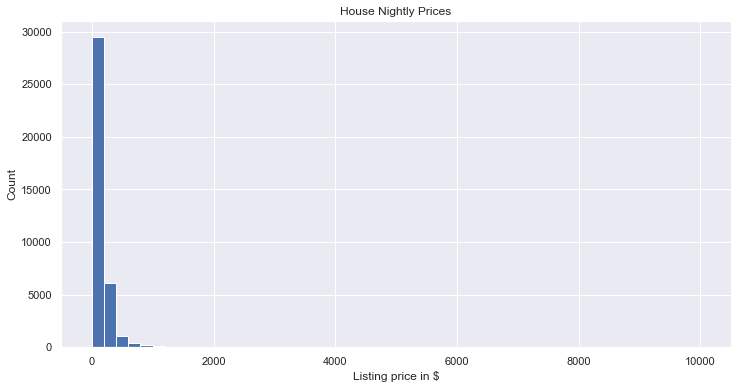

In [675]:
plt.figure(figsize=(12,6))
df_listings.price.hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Listing price in $')
plt.title('House Nightly Prices');

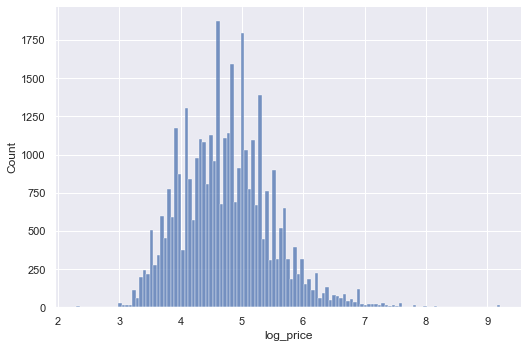

In [676]:
df_listings.loc[:,"log_price"] = np.log(df_listings.loc[:,"price"])
sns.displot(data=df_listings, x="log_price", kind="hist", aspect=1.5)

<AxesSubplot:xlabel='price'>

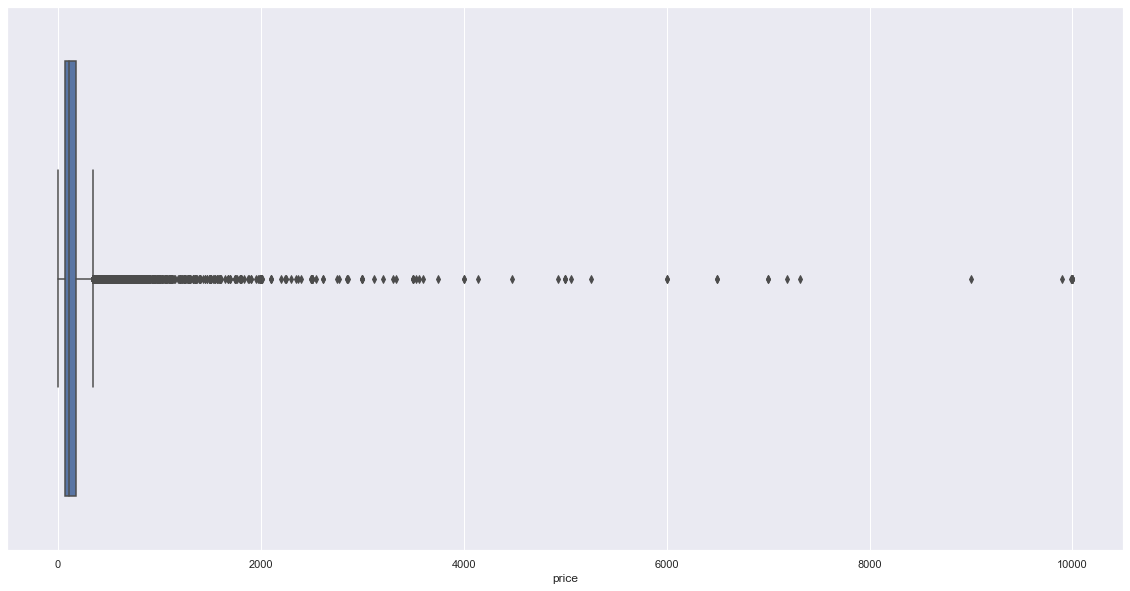

In [677]:
sns.boxplot(df_listings.price)

Assiginign percentiles for every price - so we can focus on the main and ignore the outliers for the sake of EDA and understanding our data

In [678]:
df_listings['price_percentile'] = df_listings.price.rank(pct = True)

#### Explloring  our long tail of Decile 9

<AxesSubplot:xlabel='price'>

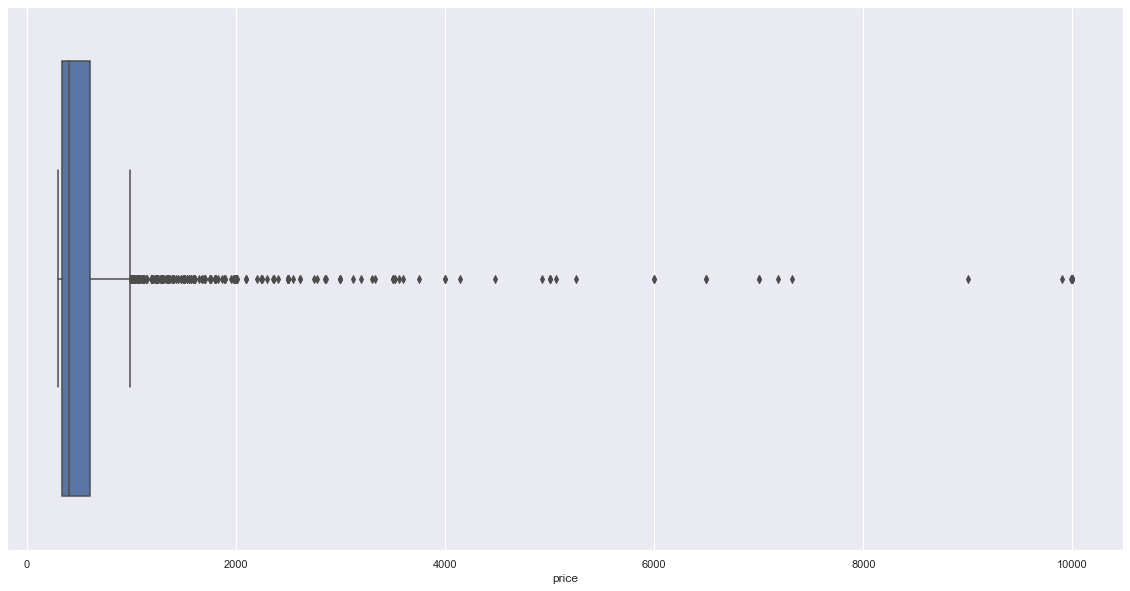

In [679]:
sns.boxplot(df_listings[df_listings.price_percentile>0.9]['price'])

Examing the price boxplot without outliers makes more sense for understanding the general trend without outliers skewing the general patern

<AxesSubplot:xlabel='price'>

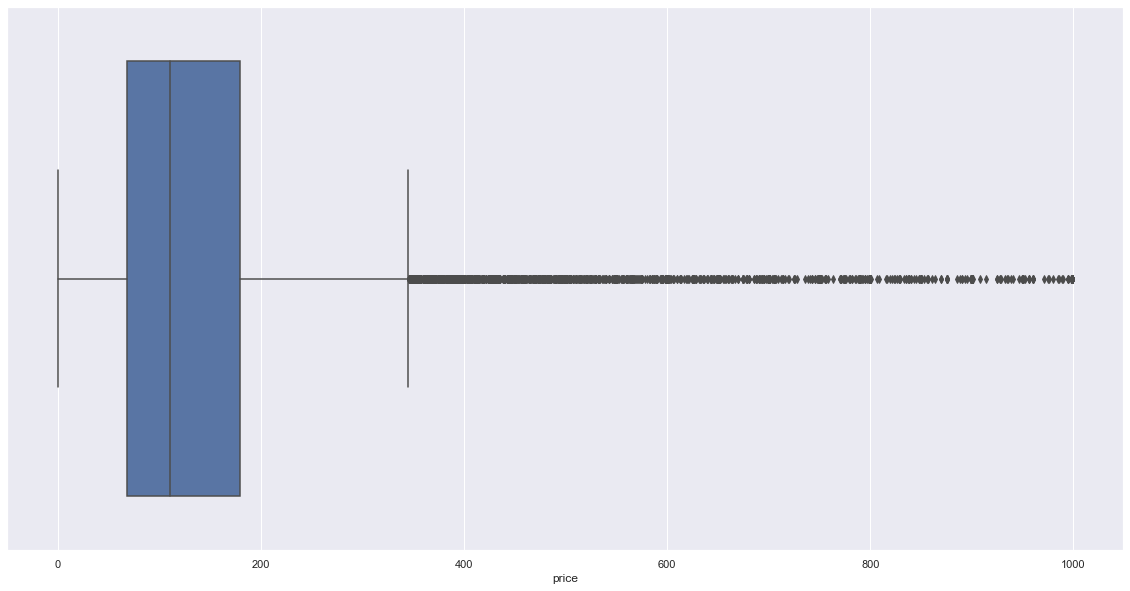

In [680]:
sns.boxplot(df_listings[df_listings.price_percentile<0.99]['price'])

### General EDA - Understanding our Data

In [681]:
df_listings.head(2)

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,verification_email,verification_phone,verification_reviews,verification_offline_government_id,verification_kba,verification_selfie,verification_government_id,verification_identity_manual,verification_work_email,verification_facebook,verification_google,verification_sent_id,verification_manual_online,verification_jumio,verification_sesame,essentials,pool,kitchen,washer,parking,elevator,hot_tub,gym,wifi,tv,heat,AC,fireplace,pets_allowed,lock,bathroom_qty,bathroom_type,logreviews,bedrooms_per_accommodates,days_host_since,days_first_to_last,days_since_last_review,log_price,price_percentile
0,a few days or more,44,18,f,5.0,1.0,1.0,Manhattan,Entire rental unit,Entire home/apt,1,5.0,1.0,150.0,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,t,30,60,77,334,48,0,0,4.70,4.72,4.62,4.76,4.79,4.86,4.41,f,3,3,0,0,0.32,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,1,0,0,0,1,bath,3.891820,5.0,5039.0,3635.0,966.0,5.010635,0.655510
1,Missing,-1,100,f,1.0,1.0,1.0,Brooklyn,Private room in rental unit,Private room,2,1.0,1.0,60.0,30,730,30.0,30.0,730.0,730.0,30.0,730.0,t,30,60,90,365,50,0,0,4.52,4.22,4.09,4.91,4.91,4.47,4.52,f,2,0,2,0,0.32,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,NaN,NaN,3.931826,0.5,4892.0,3840.0,938.0,4.094345,0.201058


We can see that hosts that answers within an hour have the highest # of reviews and the highest score

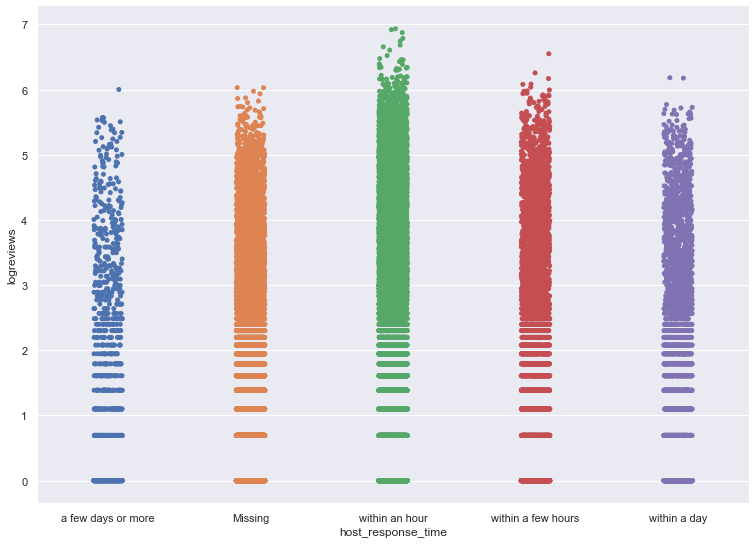

In [682]:
sns.catplot(data=df_listings, x='host_response_time', y='logreviews')
plt.gcf().set_size_inches(11.7, 8.27)

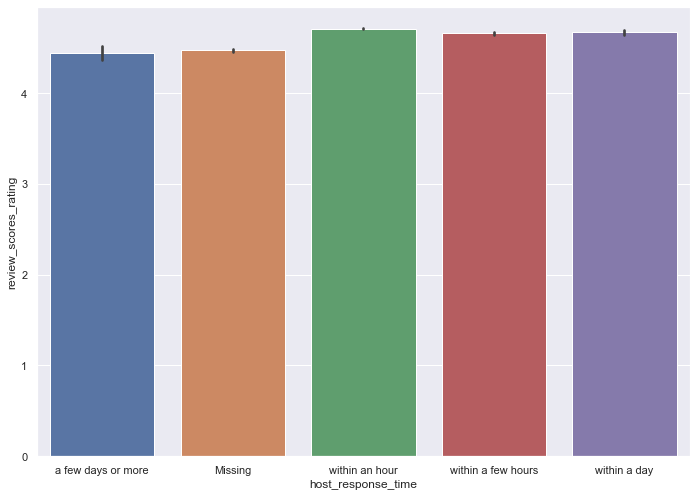

In [683]:
sns.barplot(data=df_listings, x='host_response_time', y='review_scores_rating')
plt.gcf().set_size_inches(11.7, 8.27)

#### Listings User Score Analysis

<u>Key takeaway</u>: The score mean is high, 4.6 with STD of 0.7. Meidan is higher, 4.82 

In [684]:
df_listings.review_scores_rating.dropna().median(),df_listings.review_scores_rating.dropna().describe()

(4.82,
 count    28657.000000
 mean         4.605667
 std          0.786142
 min          0.000000
 25%          4.580000
 50%          4.820000
 75%          5.000000
 max          5.000000
 Name: review_scores_rating, dtype: float64)

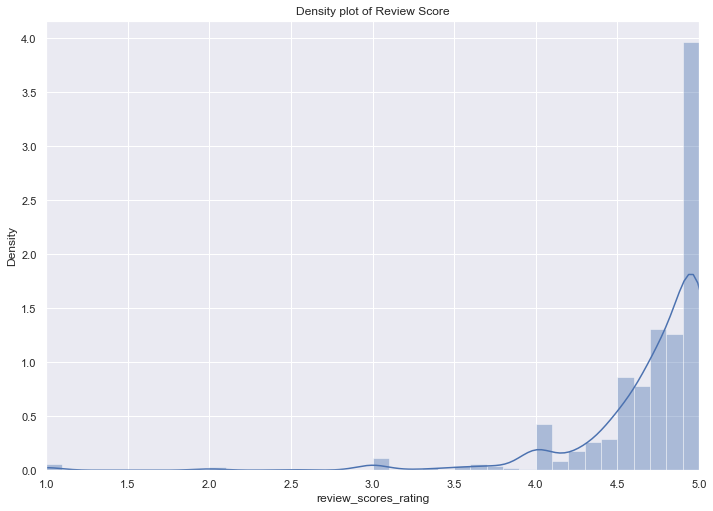

In [685]:
sns.distplot(df_listings.review_scores_rating.dropna())
plt.title('Density plot of Review Score')
plt.xlim(1,5)
plt.gcf().set_size_inches(11.7, 8.27)
plt.show()

<b>Note:</b> For the sake of EDA i'll cut the prices at 1k USD we'll use the prices of the 99th percentile 

#### Does being a SuperHost has any impact on listing price ?

<u>Key takeaway</u>: We don't see major difference between prices of superhosts vs non super hosts (didn't measure for statistical signfiicance)

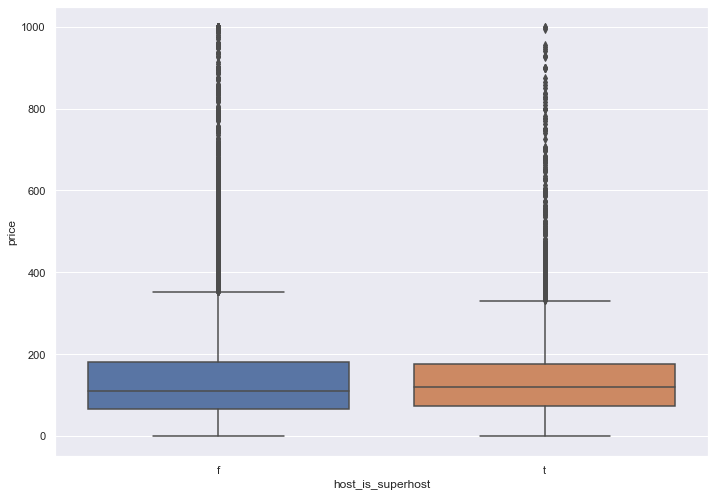

In [686]:
sns.boxplot(y='price', x='host_is_superhost', data=df_listings[df_listings.price_percentile<0.99])
plt.gcf().set_size_inches(11.7, 8.27)
plt.show();


#### Room Type and Price Analysis

<u>Key takeaway</u>: Hotel Rooms are the most expensive, then Entire Home, then Private room and finally Shared room. 

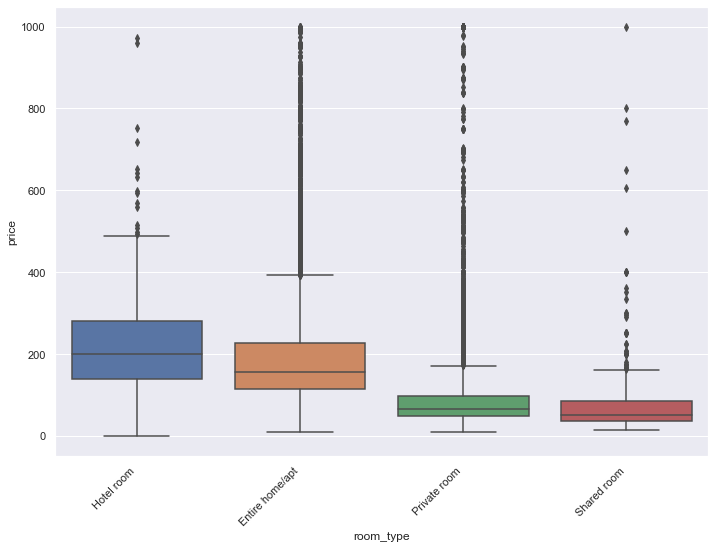

In [687]:
sort_price = df_listings[df_listings.price_percentile<0.99].groupby('room_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='room_type', data=df_listings[df_listings.price_percentile<0.99], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.gcf().set_size_inches(11.7, 8.27)
plt.show();


#### House Properties VS Price : Number of Beds, Bedrooms, Number of people it accomodates

<u>Key takeaway</u>: As might sound reasonable, in general, we observe that more beds/bedrooms/people it accomodates increases the median and average price of the listing 

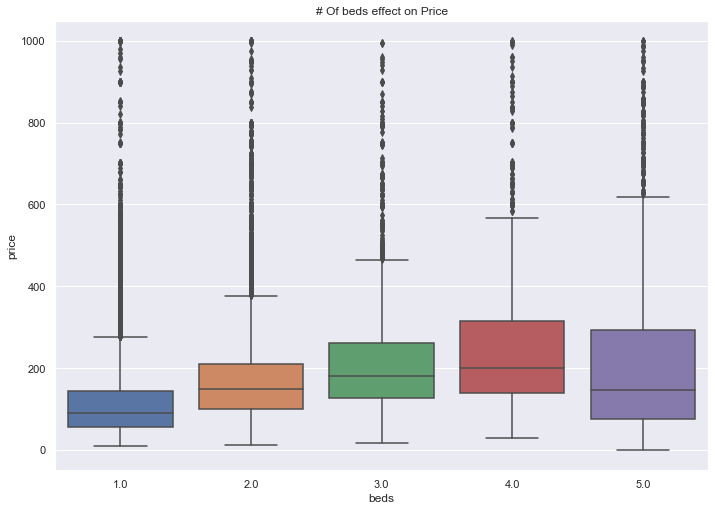

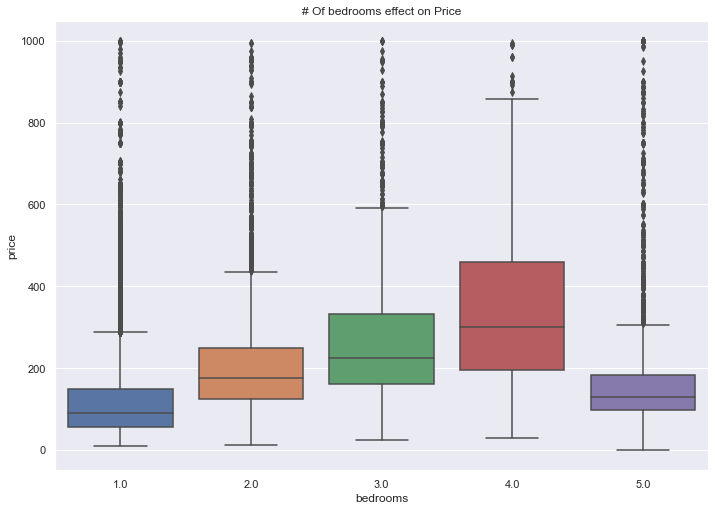

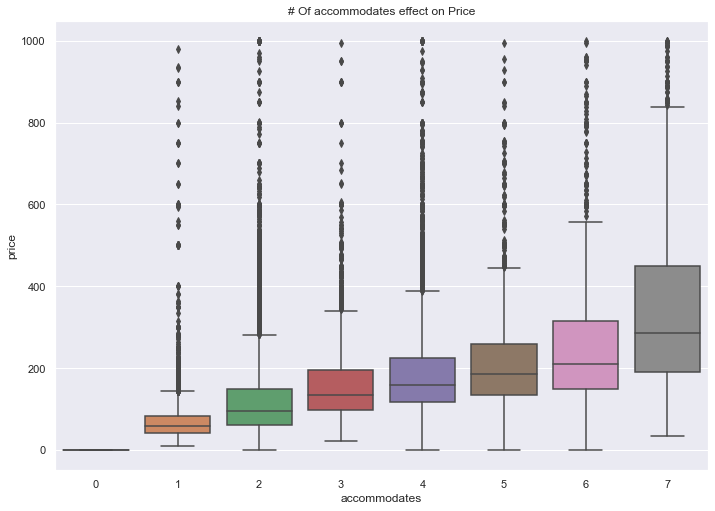

In [692]:
for var in ['beds','bedrooms','accommodates']:
    sns.boxplot(y='price', x=var, data = df_listings[df_listings.price_percentile<0.99])
    plt.title(f'# Of {var} effect on Price')
    plt.gcf().set_size_inches(11.7, 8.27)
    plt.show()

#### Host Properties VS Price : Super Host, Verification Status, Profile Picture

<u>Key takeaway</u>: We see some positive correalation between host positive features and night price (the superhost, verified or have profile picture)

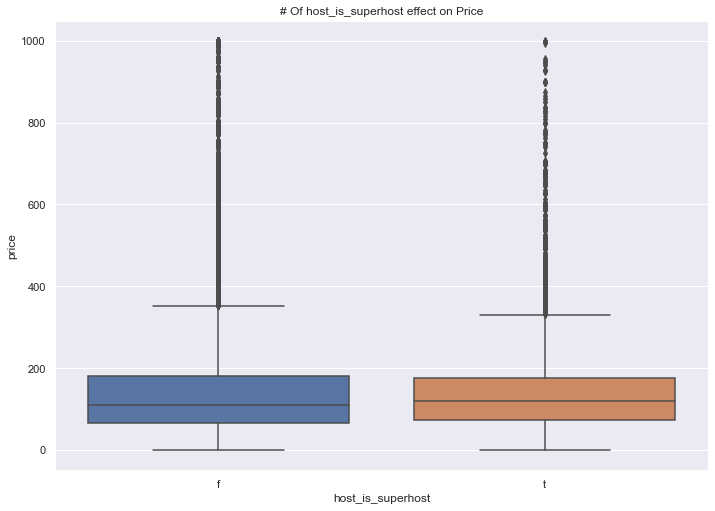

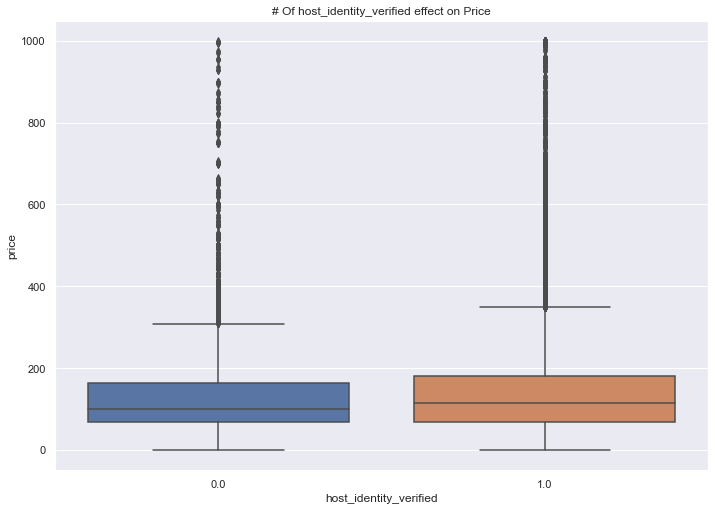

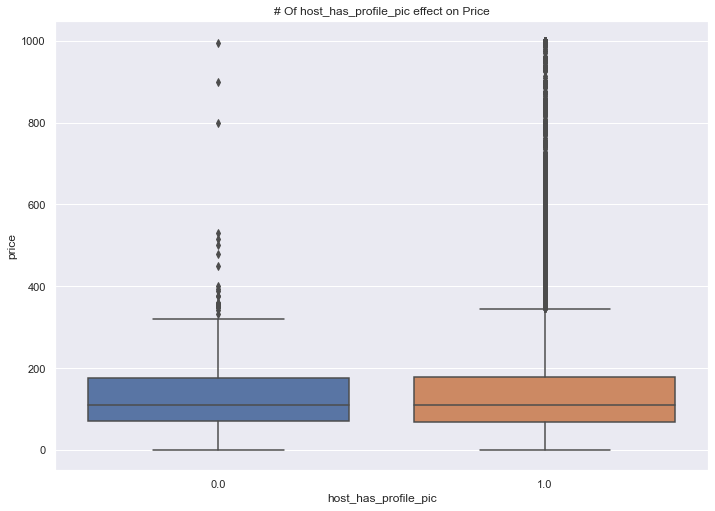

In [695]:
for var in ['host_is_superhost','host_identity_verified','host_has_profile_pic']:
    sns.boxplot(y='price', x=var, data = df_listings[df_listings.price_percentile<0.99])
    plt.title(f'# Of {var} effect on Price')
    plt.gcf().set_size_inches(11.7, 8.27)
    plt.show()

##### Checking Price correlation with relevant features, broken down to Neighbourhood Group

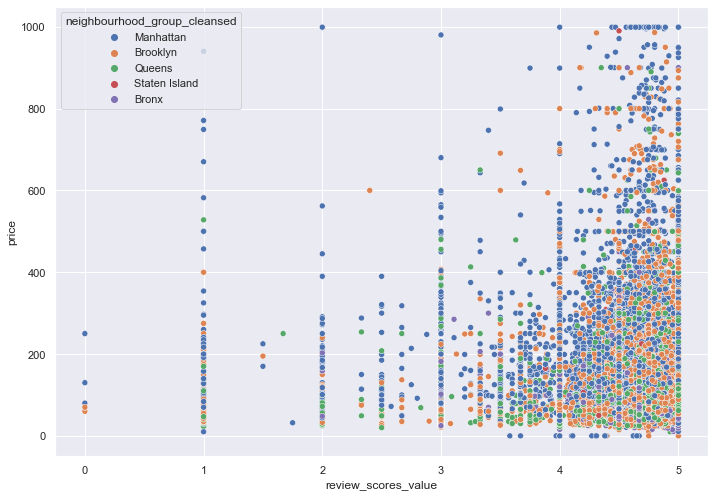

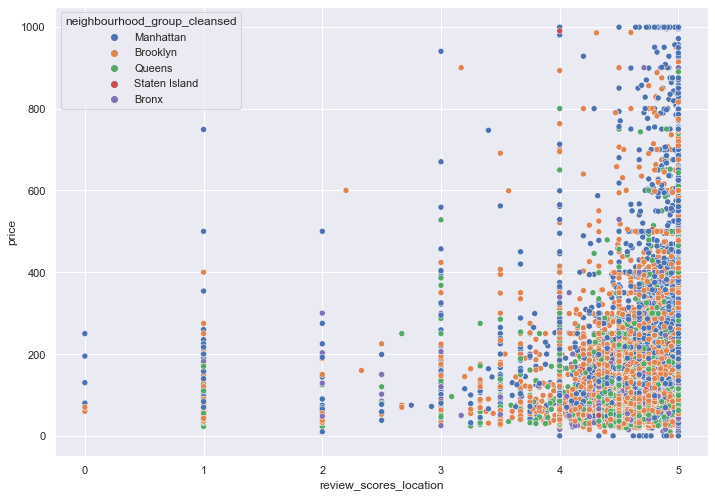

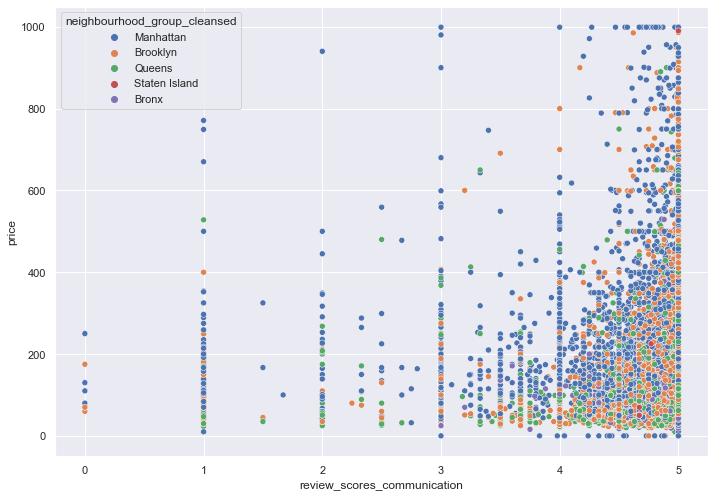

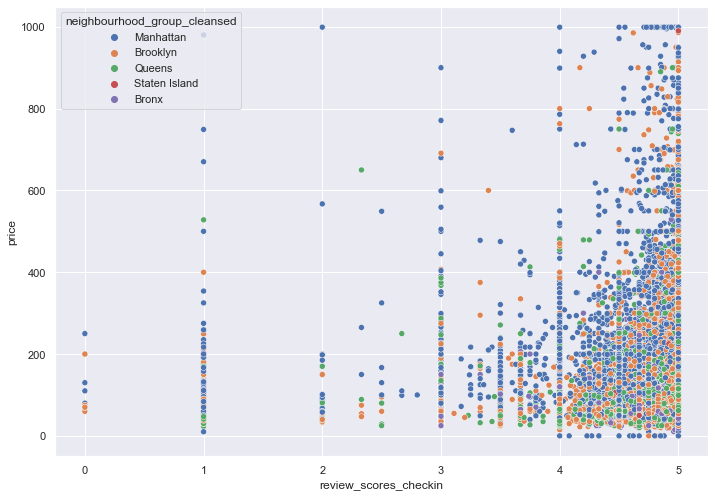

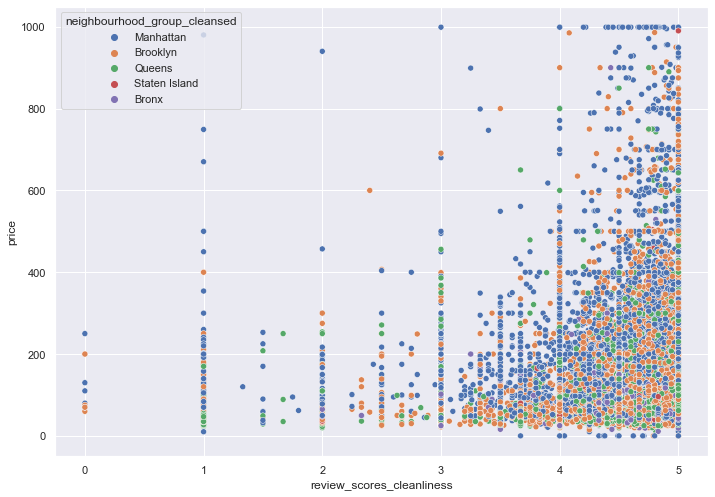

In [697]:
for var in ['review_scores_value','review_scores_location','review_scores_communication','review_scores_checkin','review_scores_cleanliness']:
    sns.scatterplot(data=df_listings[df_listings.price_percentile<0.99],x=var, y='price', hue='neighbourhood_group_cleansed')
    plt.gcf().set_size_inches(11.7, 8.27)
    plt.show();


# ML Model Training

### Procedure and intent

<p> <b>Goal (Intent):</b><p> Predicting the listing Price (target variable) of the Airbnb listing property using meta-data features of the airbnb, as close as possible 
<p> <b>Procedure </b><p>
<p>We are going to conduct the following steps:</p>
<ul>    
    <li> (1) Create dummy variables for cateogrical variables, so we can use them in veraity of ML Models (Might be optional because Catboost and LGBM can handle this without this step) </li>
    <li> (2) Impute Missing Values based on data type </li>
    <li> (3) Training the selected features on multiple models, predicting on the test set, in cross validation. Then, chooseing the one who best optimizies our success criteria - RMSE. We do this, as it can offer insights to the problem at hand by showcasing importance of every feature coresponding to our target variable - by benchmarking all models next to each other </li>  
	<li> Features Used </li>
    <ul>       
        <li> Listings Reviews Features: Scores on all parameters, Dates, Quantity and quality, etc) </li>
        <li> Prpoerty Phisical Features: Type, Size, # Of Beds, # of Bathrooms, Amenetis of the property, etc </li>
        <li> Property Location Features: Neighborhood information </li>
        <li> Listings Host parameters: Host verification status, Host availbality, responsiveness, etc </li>
    </ul> 


<p>  (4) Optimizing parameters to minimize RMSE, MAE

Summary: (LightGBM Won on both metrics)
<style type="text/css">
  table.tableizer-table {
    font-size: 12px;
    border: 1px solid #CCC;
    font-family: Arial, Helvetica, sans-serif;
  }

  .tableizer-table td {
    padding: 4px;
    margin: 3px;
    border: 1px solid #CCC;
  }

  .tableizer-table th {
    background-color: #104E8B;
    color: #FFF;
    font-weight: bold;
  }
</style>
<table class="tableizer-table">
  <thead>
    <tr class="tableizer-firstrow">
      <th>Model</th>
      <th>Error (RMSE)</th>
      <th>Error (MAE)</th>
      <th>Number of training estimators</th>
      <th>Final hyperparameter</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>CatBoost</td>
      <td>281.262368</td>
      <td>80.708363</td>
      <td>150</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td>XGBoost</td>
      <td>299.538616</td>
      <td>88.461187</td>
      <td>150</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td>LightGBM</td>
      <td>278.105574</td>
      <td>80.929834</td>
      <td>150</td>
      <td>"{'colsample_bytree': 0.65, 'learning_rate': 0.17, 'num_leaves': 15, 'reg_lambda': 1, 'subsample': 0.8, 'subsample_freq': 9, 'n_estimators': 243}"
    <tr>
      <td>DecisionTree</td>
      <td>288.070251</td>
      <td>83.026987</td>
      <td>NA</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td>RandomForest</td>
      <td>303.961269</td>
      <td>89.30005</td>
      <td>150</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td>Ridge</td>
      <td>27516.63607</td>
      <td>686.11535</td>
      <td>NA</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td>Lasso</td>
      <td>16670.07754</td>
      <td>280.862053</td>
      <td>NA</td>
      <td></td>
    </tr>
  </tbody>
</table>

<p>  (5) Extracting Feature importance, and creating lean model with top 10 features from SHAP </p>

#### (1) Dummy Variables

In [698]:
df_listings.drop(columns=['price_percentile','log_price'], inplace=True, errors='ignore')
df_listings.replace([np.inf, -np.inf], np.nan, inplace=True)

X = pd.get_dummies(df_listings.drop(columns=['price']))
y = df_listings.price

#### (2) Impute Missing Values

In [699]:
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Categorical pipeline
categorical_preprocessing = Pipeline(
[('Imputation', SimpleImputer(strategy='most_frequent'))]
)
# Continuous pipeline
continuous_preprocessing = Pipeline(
[    ('Imputation', SimpleImputer(missing_values=np.nan, strategy='mean'))]
)
# Creating preprocessing pipeline
preprocessing = make_column_transformer(
    (continuous_preprocessing, num_cols),
    (categorical_preprocessing, cat_cols),
)

# Final pipeline
pipeline = Pipeline(
    [('Preprocessing', preprocessing)]
)

X_trans = pipeline.fit_transform(X)

X_trans_df = pd.DataFrame(X_trans, columns= num_cols + cat_cols)
X = X_trans_df

#### (3) Training the selected features on multiple models

In [700]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [712]:
lgbm_model = LGBMRegressor(n_estimators=50, random_state=42)
catboost_model = CatBoostRegressor(iterations=50, random_state=42)
xgb_model = XGBRegressor(objective='reg:squarederror',n_estimators=50, random_state=42)
rf_model = RandomForestRegressor(n_estimators=25, random_state=42)
tree_model = DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25, random_state=42)
ridge_model = Ridge(alpha=75.0, random_state=42)
lasso_model = Lasso(alpha=0.75, random_state=42)

### MSE

Learning rate set to 0.5
0:	learn: 297.8936660	total: 6.57ms	remaining: 322ms
1:	learn: 288.7192062	total: 12.5ms	remaining: 300ms
2:	learn: 283.6404766	total: 17.7ms	remaining: 277ms
3:	learn: 281.6208164	total: 22.4ms	remaining: 258ms
4:	learn: 279.4974486	total: 27.1ms	remaining: 244ms
5:	learn: 279.0789623	total: 32.4ms	remaining: 238ms
6:	learn: 268.5171207	total: 37.8ms	remaining: 232ms
7:	learn: 265.4431801	total: 42.6ms	remaining: 224ms
8:	learn: 257.1008501	total: 48ms	remaining: 219ms
9:	learn: 256.6387881	total: 53ms	remaining: 212ms
10:	learn: 252.2518862	total: 57.5ms	remaining: 204ms
11:	learn: 250.2364983	total: 62.1ms	remaining: 197ms
12:	learn: 249.7414154	total: 66.9ms	remaining: 191ms
13:	learn: 246.3648437	total: 71.9ms	remaining: 185ms
14:	learn: 245.6979891	total: 76.4ms	remaining: 178ms
15:	learn: 245.4519515	total: 81.3ms	remaining: 173ms
16:	learn: 243.5369866	total: 86ms	remaining: 167ms
17:	learn: 242.1459117	total: 90.8ms	remaining: 161ms
18:	learn: 240.8592

<AxesSubplot:xlabel='Model'>

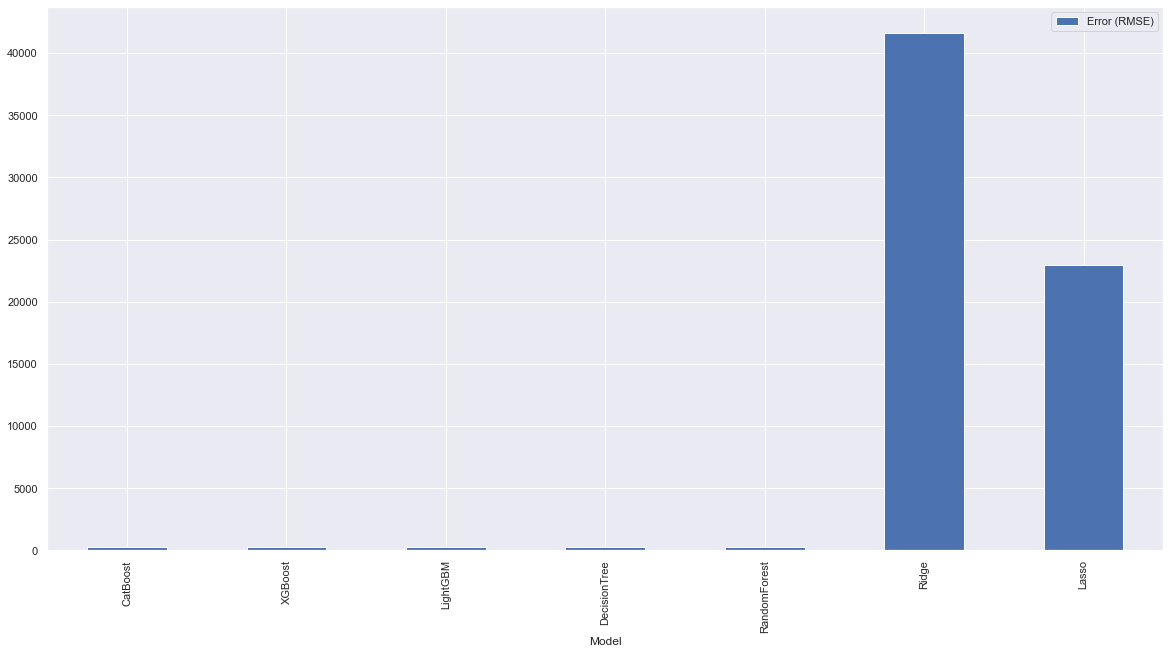

In [721]:
models = [
    ('CatBoost', catboost_model),
    ('XGBoost', xgb_model),
    ('LightGBM', lgbm_model),
    ('DecisionTree', tree_model),
    ('RandomForest', rf_model),
    ('Ridge', ridge_model),
    ('Lasso', lasso_model),
]

scores = [-1.0 * cross_val_score(model, X,y, scoring='neg_root_mean_squared_error').mean() for _,model in models]

data_result = pd.DataFrame({ 'Model': [name for name, _ in models], 'Error (RMSE)': scores })
data_result.plot(x='Model', kind='bar')

In [723]:
pd.DataFrame(data_result)

,Model,Error (RMSE)
0,CatBoost,293.023538
1,XGBoost,289.726123
2,LightGBM,277.797387
3,DecisionTree,286.134898
4,RandomForest,308.101052
5,Ridge,41627.696229
6,Lasso,22972.122335


Learning rate set to 0.5
0:	learn: 297.8936660	total: 6.46ms	remaining: 317ms
1:	learn: 288.7192062	total: 13.1ms	remaining: 314ms
2:	learn: 283.6404766	total: 19.2ms	remaining: 301ms
3:	learn: 281.6208164	total: 24.6ms	remaining: 283ms
4:	learn: 279.4974486	total: 30ms	remaining: 270ms
5:	learn: 279.0789623	total: 35.3ms	remaining: 259ms
6:	learn: 268.5171207	total: 40.5ms	remaining: 249ms
7:	learn: 265.4431801	total: 45.5ms	remaining: 239ms
8:	learn: 257.1008501	total: 50.9ms	remaining: 232ms
9:	learn: 256.6387881	total: 56.2ms	remaining: 225ms
10:	learn: 252.2518862	total: 61.4ms	remaining: 218ms
11:	learn: 250.2364983	total: 66.4ms	remaining: 210ms
12:	learn: 249.7414154	total: 71.4ms	remaining: 203ms
13:	learn: 246.3648437	total: 76.5ms	remaining: 197ms
14:	learn: 245.6979891	total: 81.6ms	remaining: 190ms
15:	learn: 245.4519515	total: 87.1ms	remaining: 185ms
16:	learn: 243.5369866	total: 92.7ms	remaining: 180ms
17:	learn: 242.1459117	total: 98ms	remaining: 174ms
18:	learn: 240.85

<AxesSubplot:xlabel='Model'>

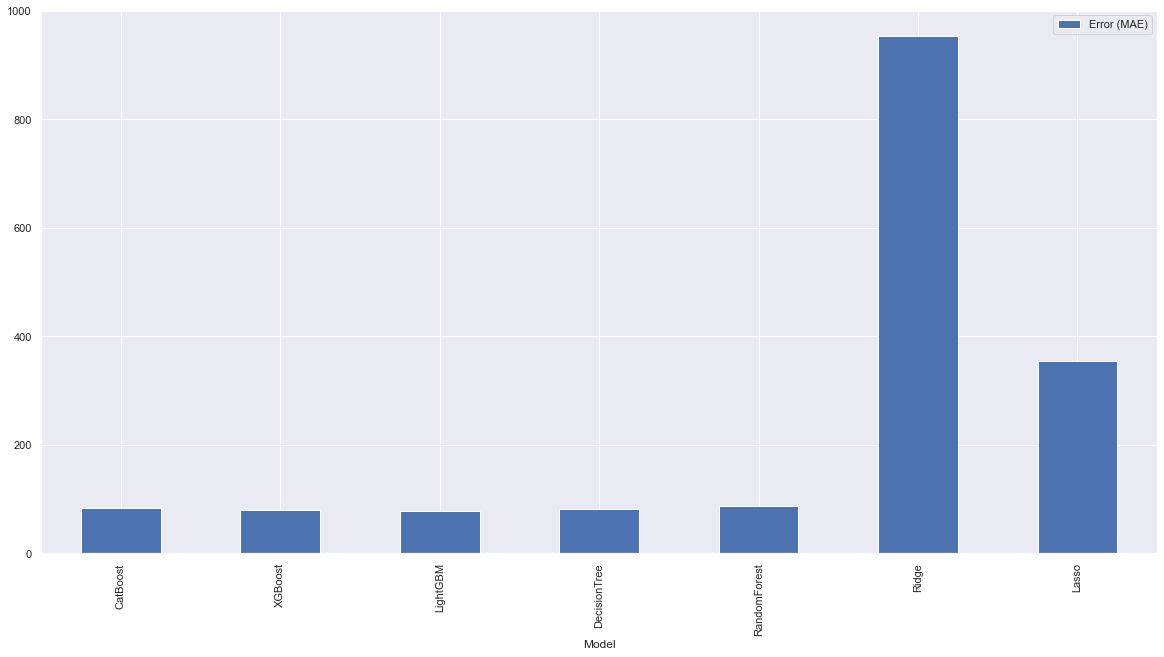

In [727]:
models = [
    ('CatBoost', catboost_model),
    ('XGBoost', xgb_model),
    ('LightGBM', lgbm_model),
    ('DecisionTree', tree_model),
    ('RandomForest', rf_model),
    ('Ridge', ridge_model),
    ('Lasso', lasso_model),
]

scores = [-1.0 * cross_val_score(model, X,y, scoring='neg_mean_absolute_error').mean() for _,model in models]

data_result = pd.DataFrame({ 'Model': [name for name, _ in models], 'Error (MAE)': scores })
data_result.plot(x='Model', kind='bar')

In [728]:
pd.DataFrame(data_result)

,Model,Error (MAE)
0,CatBoost,82.878227
1,XGBoost,79.543184
2,LightGBM,77.329934
3,DecisionTree,81.436959
4,RandomForest,88.097745
5,Ridge,954.322585
6,Lasso,353.828895


##### (4)  Optimizing parameters to minimize RMSE, MAE with the best model (LightGBM)

In [729]:
param_grid = {"subsample": [0.8,0.9,1],
              "subsample_freq":[9,10,11],
              "learning_rate":[0.09,0.1,0.11,0.12,0.13,0.15],
               "reg_lambda": [1,6],
               "colsample_bytree": [0.65, 0.75, 0.8],
               'num_leaves': [5, 15,30],
              }

search = HalvingGridSearchCV(lgbm_model, param_grid, resource='n_estimators',
                             max_resources=250,
                             random_state=0).fit(X, y)
search.best_params_  

{'colsample_bytree': 0.65,
 'learning_rate': 0.15,
 'num_leaves': 15,
 'reg_lambda': 6,
 'subsample': 1,
 'subsample_freq': 11,
 'n_estimators': 243}

Trial and Error on setting parameters values

In [731]:
best_params = {'learning_rate': 0.07,
 'subsample': 0.7,
 'subsample_freq': 5,
 'n_estimators': 9}

best_params_2 = {'learning_rate': 0.07,
 'subsample': 0.9,
 'subsample_freq': 10,
 'n_estimators': 135,
 'max_depth':10,
 'reg_lambda': 6}

best_params_3 = {'learning_rate': 0.11,
 'subsample': 0.9,
 'subsample_freq': 10,
 'n_estimators': 135}

best_params_4 = {'colsample_bytree': 0.65,
 'learning_rate': 0.15,
 'reg_lambda': 6,
 'subsample': 1,
 'subsample_freq': 9,
 'n_estimators': 243}

best_params_5 = {'colsample_bytree': 0.65,
 'learning_rate': 0.17,
 'num_leaves': 15,
 'reg_lambda': 6,
 'subsample': 1,
 'subsample_freq': 11,
 'n_estimators': 243}

lgbm_model_best = LGBMRegressor(**best_params_5, objective='regression_l1')

Training best model and measuring MAE in USD

In [732]:
lgbm_model_best.fit(X_train,y_train)
mean_absolute_error(y_true=y_test, y_pred=lgbm_model_best.predict(X_test))

57.65916502768727

Measuring best performance of the model

In [733]:
np.sqrt(mean_squared_error(y_true=y_test, y_pred=lgbm_model_best.predict(X_test)))

238.3522120609664

In [734]:
mean_absolute_error(y_true=y_test, y_pred=lgbm_model_best.predict(X_test))

57.65916502768727

#### Feature Importance (LGBM)

<AxesSubplot:xlabel='feature', ylabel='imporrtance'>

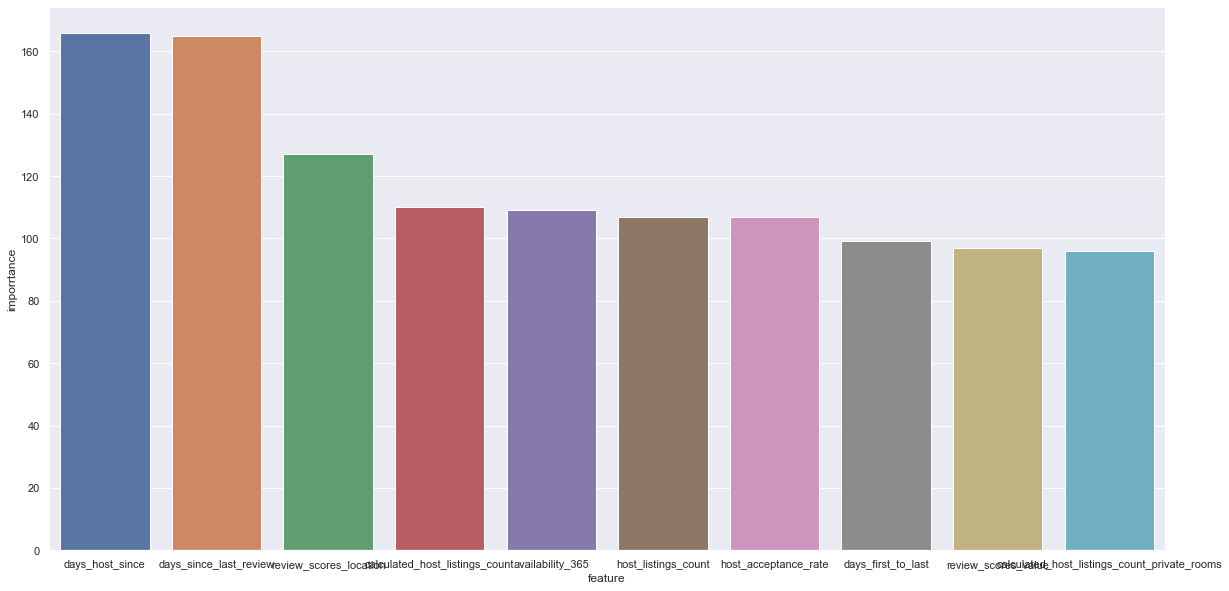

In [735]:
df_feature_importance_lgbm = pd.DataFrame(zip(X.columns,lgbm_model_best.feature_importances_)).sort_values(by=1, ascending=False)
df_feature_importance_lgbm.columns =['feature','imporrtance']
sns.barplot(data=df_feature_importance_lgbm[:10], x='feature', y='imporrtance')

### Feature Imporrtance (Using SHAP)

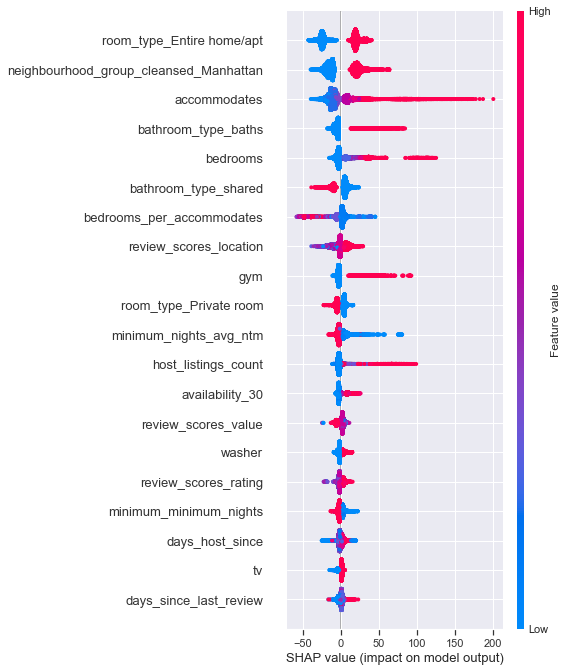

In [736]:
explainer = shap.TreeExplainer(lgbm_model_best)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


#### (5) Extracting Feature importance, and creating lean model with top 10 features from SHAP

In [738]:
features = X.columns
mask = np.abs(shap_values).mean(0).argsort()[::-1]
top_10 = features[mask][:10]
top_10

Index(['room_type_Entire home/apt', 'neighbourhood_group_cleansed_Manhattan',
       'accommodates', 'bathroom_type_baths', 'bedrooms',
       'bathroom_type_shared', 'bedrooms_per_accommodates',
       'review_scores_location', 'gym', 'room_type_Private room'],
      dtype='object')

For UI Purposes building a model just with the top 10 features

In [754]:
X_new, y = X[top_10], y
best_params = {'colsample_bytree': 0.65,
 'learning_rate': 0.17,
 'num_leaves': 15,
 'reg_lambda': 1,
 'subsample': 0.8,
 'subsample_freq': 9,
 'n_estimators': 243}

lgbm_model_best = LGBMRegressor(**best_params, objective='regression_l1', random_state=42)
scores = [-1.0 * cross_val_score(lgbm_model_best, X_new,y, scoring='neg_mean_absolute_error').mean()]
scores

[68.85880402153956]

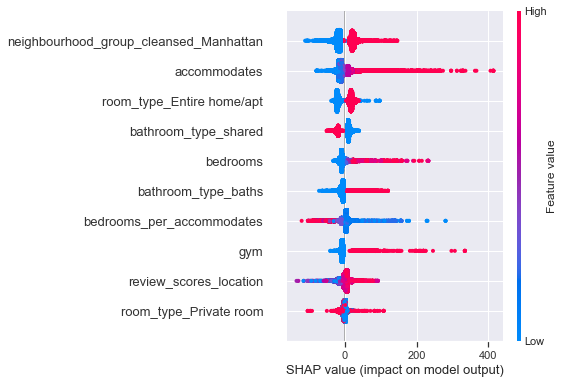

In [755]:
lgbm_model_best.fit(X_new,y)
explainer = shap.TreeExplainer(lgbm_model_best)
shap_values = explainer.shap_values(X_new)
shap.summary_plot(shap_values, X_new)

In [753]:
#shap.plots.waterfall(shap_values)

### Saving the model, creating Pickles for UI

##### Saving the model to a pickle file

In [760]:
pickle_out = open("c:/castpone/top_10_model.pkl", mode = "wb") 
pickle.dump(lgbm_model_best, pickle_out) 
pickle_out.close()

##### Saving the final features as a pickle file

In [761]:
X_new.to_csv("C:\castpone\X_new.csv",index=False)

In [745]:
X_new.head()

,room_type_Entire home/apt,neighbourhood_group_cleansed_Manhattan,accommodates,bathroom_type_baths,bedrooms,bathroom_type_shared,bedrooms_per_accommodates,review_scores_location,gym,room_type_Private room
0,1.0,1.0,1.0,0.0,5.0,0.0,5.0,4.86,0.0,0.0
1,0.0,0.0,2.0,0.0,1.0,0.0,0.5,4.47,0.0,1.0
2,1.0,0.0,4.0,1.0,2.0,0.0,0.5,4.50,0.0,0.0
3,0.0,1.0,2.0,0.0,1.0,0.0,0.5,4.87,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,4.94,0.0,1.0


##### Saving a dataframe with features , predictions and real labels

In [762]:
y_pred = pd.Series(lgbm_model_best.predict(X_new)).rename('Predicted_Price')
df_final = pd.concat([X_new,y_pred,y],axis=1)
df_final['Error'] = df_final.price - df_final.Predicted_Price
df_final.to_csv("C:\castpone\df_final.csv",index=False)

In [764]:
X_new.columns

Index(['room_type_Entire home/apt', 'neighbourhood_group_cleansed_Manhattan',
       'accommodates', 'bathroom_type_baths', 'bedrooms',
       'bathroom_type_shared', 'bedrooms_per_accommodates',
       'review_scores_location', 'gym', 'room_type_Private room'],
      dtype='object')

Plotting Predictions vs Actual for the top 10 features model

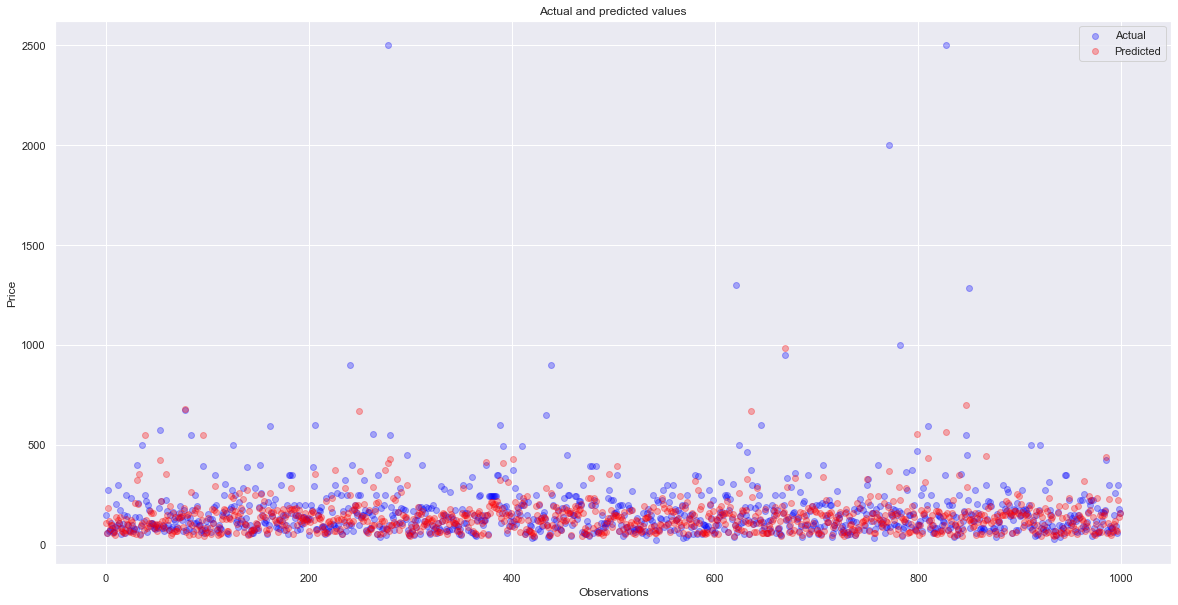

In [744]:
_, ax = plt.subplots()
y_pred, y_test = df_final.Predicted_Price[:1000], df_final.price[:1000]

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

### ML Model Results and Discussion

<h3> Chosen Success Criteria (Performance Metrics)</h3>
<p> I chose to compare all models with both MAE and MSE </p>
<li> <b>MAE (Mean absolute error)</b> represents the difference between the original and predicted values extracted by averaged the absolute difference over the data set. </li>
-> On our case, it will measure the absolute gap in USD between the predicted and actual price for the listing
<li> <b>MSE (Mean Squared Error)</b> represents the difference between the original and predicted values extracted by squared the average difference over the data set. </li>

In both cases the best model was Light GBM.

<h3> How will my model be used ?</h3>
<p>It's a POC to evaluate the capabilities of analyzing the price data. If I want to rent an airbnb, I can find what are the features that will help me maximize my demand price. </p>

<h3> What do the model results suggest about the problem at hand ?</h3>
<p>Suprisingly, among the top features we see lots of features that belongs to the host (verification etc) - combiniation of good host attributes and big house yields the highest listing price</p>
